# Heston Pricing

In [16]:
from scipy.integrate import quad
import cmath
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
from scipy.optimize import bisect
from scipy.stats import norm

Recall the following option price formula for a European Call option with maturity $T$ and strike $K$:
$$
\mathbb{E}\left[S_T - \mathrm{e}^{k}\right]_+ = S_0\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi-\mathrm{i})}{\mathrm{i}\xi\Phi_T(-\mathrm{i})}
 \mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d} \xi\right) - K\mathrm{e}^{-rT}\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi)}{\mathrm{i}\xi}\mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d}
 \xi\right) =: S_0 \Pi_1 - K\mathrm{e}^{-rT}\Pi_2
$$
where $\Phi_T(\xi):=\mathbb{E}[S_T^{\mathrm{i}\xi}]$
is the characteristic function of the log-stock price at time $T$.

We shall use here the slightly-rewritten expression, $K:=S_0\mathrm{e}^{k}$:
$$
\mathbb{E}\left[S_T - K\right]_+ = S_0\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi-\mathrm{i})}{\mathrm{i}\xi}
 \mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d} \xi\right)- K\mathrm{e}^{-rT}\left(\frac{1}{2}+\frac{1}{\pi}\int_{0}^{\infty}\Re\left(\frac{\Phi_T(\xi)}{\mathrm{i}\xi}\mathrm{e}^{-\mathrm{i} k\xi}\right)\mathrm{d}
 \xi\right) =: S_0 \Pi_1 - K\mathrm{e}^{-rT}\Pi_2,
$$

### Characteristic function, as proposed by Heston

$\Phi_T(\xi) = \exp\Big(C_T(\xi) + D_T(\xi)V_0 + \mathrm{i}\xi \log(S_0)\Big)$, where
$$
C_T(\xi) : = \mathrm{i}r\xi T + \frac{\kappa\theta}{\sigma^2}\left\{\left(\kappa-\mathrm{i}\rho\sigma\xi+d_T(\xi)\right)T
- 2\log\left(\frac{1-\gamma_T(\xi)\mathrm{e}^{d_T(\xi)T}}{1-\gamma_T(\xi)}\right)\right\},
$$
$$
D_T(\xi) : = \frac{\kappa - \mathrm{i}\rho\sigma\xi + d_T(\xi)}{\sigma^2}
\left(\frac{1-\mathrm{e}^{d_T(\xi)T}}{1-\gamma_T(\xi)\mathrm{e}^{d_T(\xi)T}}\right),
$$
$$
\gamma_T(\xi) := \frac{\kappa-\rho\sigma - \mathrm{i}\rho\sigma\xi + d_T(\xi)}
{\kappa-\rho\sigma - \mathrm{i}\rho\sigma\xi - d_T(\xi)},
\qquad 
d_T(\xi) := \sqrt{(\kappa-\rho\sigma-\mathrm{i}\rho\sigma\xi)^2 + \sigma^2(\mathrm{i}\xi - \xi^2)}.
$$
Note that this characteristic function may have branch-cut issues

### Characteristic function used in Albrecher and Gatheral

$\Phi_T(\xi) = \exp\Big(C_T(\xi) + D_T(\xi)V_0 + \mathrm{i}\xi \log(S_0)\Big)$, where
$$
C_T(\xi) : = \mathrm{i}r\xi T + \frac{\kappa\theta}{\sigma^2}\left\{\left(\kappa-\mathrm{i}\rho\sigma\xi-d_T(\xi)\right)T
- 2\log\left(\frac{1-\gamma_T(\xi)\mathrm{e}^{-d_T(\xi)T}}{1-\gamma_T(\xi)}\right)\right\},
$$
$$
D_T(\xi) : = \frac{\kappa - \mathrm{i}\rho\sigma\xi - d_T(\xi)}{\sigma^2}
\left(\frac{1-\mathrm{e}^{-d_T(\xi)T}}{1-\gamma_T(\xi)\mathrm{e}^{-d_T(\xi)T}}\right),
$$
$$
\gamma_T(\xi) := \frac{\kappa - \mathrm{i}\rho\sigma\xi - d_T(\xi)}{\kappa - \mathrm{i}\rho\sigma\xi + d_T(\xi)},
\qquad 
d_T(\xi) := \sqrt{(\kappa-\mathrm{i}\rho\sigma\xi)^2 + \sigma^2(\mathrm{i}\xi+\xi^2)}.
$$
This characteristic function does not have any branch-cut problems

### Important note:
We use the one by Albrecher / Gatheral in order to avoid the branch cut problems.

# Black-Scholes formulae

In [86]:
def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

# Heston Pricing

In [87]:
def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

In [88]:
def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), rtol=1e-15, full_output=False, disp=True)

## Numerical Example

In [107]:
# Heston parameters
kappa = 4.1
sigma = .3
rho = -0.7
v0 = 0.04
theta = 0.06
r = 0.
s0 = 1.
T = 0.4
logMoneyness = 0.1

hestonParams = kappa, theta, sigma, rho, v0 
cp = heston_EuropeanCall(hestonParams,r,T,s0,s0*np.exp(logMoneyness))
iv = heston_Impliedvol(hestonParams,r,T,s0,s0*np.exp(logMoneyness))
print("Heston Call Price: %.4f " %cp)
print("Heston Implied volatility: %.2f%%" %(100.*iv))

Heston Call Price: 0.0175 
Heston Implied volatility: 20.63%


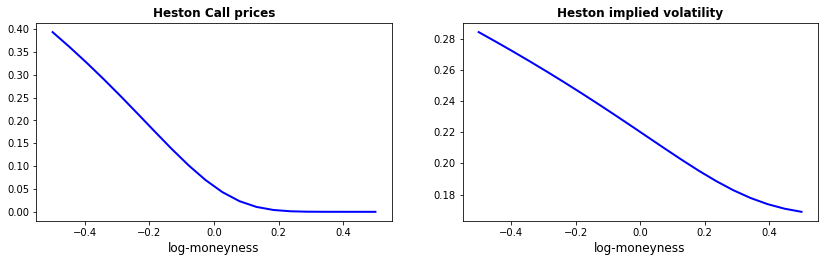

In [108]:
logMoneynesses = np.linspace(-.5, .5, 20)

calls = [heston_EuropeanCall(hestonParams,r,T,s0,s0*np.exp(x)) for x in logMoneynesses]
ivs = [heston_Impliedvol(hestonParams,r,T,s0,s0*np.exp(x)) for x in logMoneynesses]

fig = plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.plot(logMoneynesses, calls, 'b-', linewidth=2)
plt.title("Heston Call prices", fontsize=12, fontweight='bold')
plt.xlabel(u'log-moneyness', fontsize=12)
plt.subplot(2, 2, 2)
plt.plot(logMoneynesses, ivs, 'b-', linewidth=2)
plt.title("Heston implied volatility", fontsize=12, fontweight='bold')
plt.xlabel(u'log-moneyness', fontsize=12)
plt.show()